In [1]:
# Importamos las librerías necesarias
import math, random
from scipy.stats import norm, expon, truncnorm
import numpy as np
from scipy.integrate import simps
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
# Definimos funciones a utilizar según las premisas especificadas en el problema
def L_i(d, theta, theta_0):
    if d=='d_0':
        output=theta_0-theta
    elif d=='d_1':
        output=0
    return output



def P_i_x_theta(x,theta):
    normal_cond=norm(theta, theta/30)
    return normal_cond.pdf(x)



def L_a_i(d,m,theta,theta_0):
    if d=='d_0':
        output=0.9*theta-theta_0+(m**2)*theta_0/x_L_a_i
    elif d=='d_1':
        output=(m**2)*theta_0/x_L_a_i
    return output



def P_a_i_theta(theta):
    prob=norm(x_P_a_i_theta, y_P_a_i_theta)
    return prob.pdf(x)



def P_a_i_x_theta(x,theta):
    prob=norm(theta/50*x_P_a_i_x_theta+theta,theta*y_P_a_i_x_theta)
    return prob.pdf(x)



def P_i_a_i_theta(theta):
    prob=norm(x_P_i_a_i_theta,y_P_i_a_i_theta)
    return prob.pdf(theta)



def P_i_a_i_a(a):
    if a == 1:
        output = x_P_i_a_i_a[0]
    elif a == 1.05:
        output = x_P_i_a_i_a[1]
    elif a == 1.1:
        output = x_P_i_a_i_a[2]
    elif a == 1.15:
        output = x_P_i_a_i_a[3]
    return output



def h_i_a_i(y,theta,m):
    x_va=m*theta
    y_va=m*theta/chi_h_i_a_i
    prob=norm(x_va,y_va)
    return prob.pdf(y)



def f(theta):
    return sum(h_i_a_i(y,theta,m)*P_i_a_i_a(m)*P_i_a_i_theta(theta) for m  in A)

In [3]:
# Generación de P_A^i(d|y)
import time
inicio = time.time()
N1 = 200  # simulaciones
N2 = 300  # muestras
Y = np.linspace(8, 15, 701)
denominador = np.zeros(len(Y))
numerador = np.zeros(len(Y))
theta_0 = 10
X = {}
X_amp = {}
cubic_spline = {}

for n1 in range(N1):
    mu_P_i_a_i_theta = np.random.normal(loc=10, scale=0.2)
    sigma_P_i_a_i_theta = np.random.normal(loc=1, scale=0.1)
    lambda_P_i_a_i_a = np.random.chisquare(df=10)
    chi_h_i_a_i = np.random.chisquare(df=30)
    a = (5 - mu_P_i_a_i_theta) / sigma_P_i_a_i_theta
    b = (15 - mu_P_i_a_i_theta) / sigma_P_i_a_i_theta
    theta_P_i_a_i = truncnorm.rvs(a, b, loc=mu_P_i_a_i_theta, scale=sigma_P_i_a_i_theta, size=N2)
    a_P_i_a_i = np.random.exponential(scale=1 / lambda_P_i_a_i_a, size=N2) + 1

    valores_h = np.array([h_i_a_i(Y, theta, a) for theta, a in zip(theta_P_i_a_i, a_P_i_a_i)])

    denominador = valores_h.sum(axis=0)
    numerador = np.sum(valores_h * (theta_P_i_a_i > theta_0)[:, np.newaxis], axis=0)
    if np.isnan(denominador).any():
        raise ValueError("Denominador tiene valores NaN. Reiniciar cálculo.")
    X[n1] = np.where(denominador > 0, numerador / denominador, 0)
    cubic_spline[n1] = CubicSpline(Y, X[n1], extrapolate=False)
final = time.time()
print('Tiempo:', final - inicio)

Tiempo: 38.704466581344604


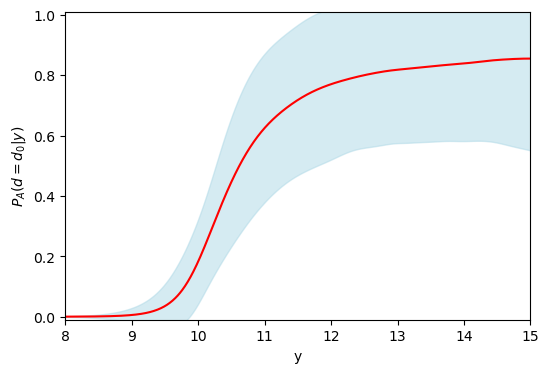

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Definición de Y y x_plot
Y = np.linspace(8, 15, 701)
x_plot = np.linspace(min(Y), max(Y), 1000)

# Generación de las curvas
curvas = np.array([cubic_spline[i](x_plot) for i in range(len(cubic_spline))])

# Cálculo de la media y la desviación estándar en cada punto x_plot
media_curvas = np.mean(curvas, axis=0)
std_curvas = np.std(curvas, axis=0)

# Gráfico de la media y el área sombreada
plt.figure(figsize=(6, 4)) 
plt.xlabel('y')
plt.ylabel(r'$P_A(d=d_0|y)$')

# Pinta la media de las curvas en rojo
plt.plot(x_plot, media_curvas, color='red')

# Rellena el área con dos desviaciones estándar alrededor de la media
plt.fill_between(x_plot, media_curvas - 2 * std_curvas, media_curvas + 2 * std_curvas, color='lightblue', alpha=0.5)

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlim(8, 15)
plt.ylim(-0.01, 1.01)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Definición de Y y x_plot
Y = np.linspace(8, 15, 701)
x_plot = np.linspace(min(Y), max(Y), 1000)

# Gráfico de todas las curvas
plt.figure(figsize=(10, 6))
plt.xlabel('y')
plt.ylabel(r'$P_A(d=d_0|y)$')

# Itera a través de todas las curvas en cubic_spline y gráficas
for i in range(len(cubic_spline)):
    y_plot = cubic_spline[i](x_plot)
    plt.plot(x_plot, y_plot, color='blue', alpha=0.3)  # Usa alpha para hacer las líneas semitransparentes

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlim(8, 15)
plt.ylim(-0.01, 1.01)
plt.title('Todas las curvas de $P_A(d=d_0|y)$ generadas usando splines cúbicos')
plt.show()


In [5]:
# Generación de P_i(a)

def f_optim(a):
    output = np.dot( (0.9*theta_P_a_i-theta_0+(a**2-1)*theta_0/x_L_a_i), cubic_spline[n]( np.clip(a*x_P_a_i, min(Y), max(Y)) ) ) + np.sum( (a**2-1)*theta_0/x_L_a_i * (1-cubic_spline[n](np.clip(a*x_P_a_i, min(Y), max(Y)))) ) 
    return output



N3 = 20000
N4 = 300 # muestras en la integral
A = []
for n3 in range(N3):
    mu_P_a_i_theta = np.random.normal(loc=10, scale=0.2)
    sigma_P_a_i_theta = truncnorm.rvs(a=(0-0.5)/0.1, b=np.inf, loc=0.5, scale=0.1)
    theta_P_a_i = np.random.normal(mu_P_a_i_theta, sigma_P_a_i_theta, N4)
    mu_P_a_i_x = np.random.normal(theta_P_a_i, theta_P_a_i/50)
    sigma_P_a_i_x = np.random.chisquare(theta_P_a_i)/30
    x_P_a_i = np.random.normal(mu_P_a_i_x, sigma_P_a_i_x)
    n = np.random.randint(0, N1)
    x_L_a_i = np.random.chisquare(df=10)
    a = minimize(f_optim, 1.1, bounds = [(1, 5)]).x[0]
    A.append(a)

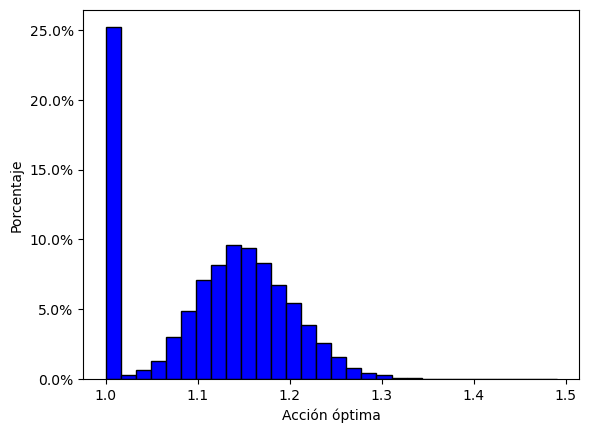

In [6]:
# Gráfico con un ejemplo de p(a)
plt.hist(A, weights=np.ones(len(A)) / len(A), bins=30, color='blue', edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Acción óptima')
plt.ylabel('Porcentaje')
plt.show()

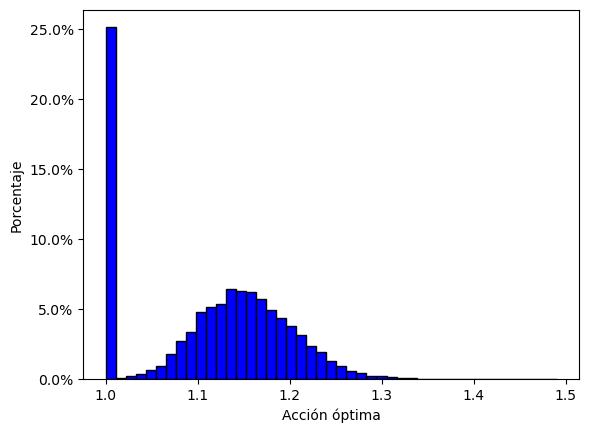

In [7]:
# Gráfico con un ejemplo de p(a)
plt.hist(A, weights=np.ones(len(A)) / len(A), bins=45, color='blue', edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Acción óptima')
plt.ylabel('Porcentaje')
plt.show()

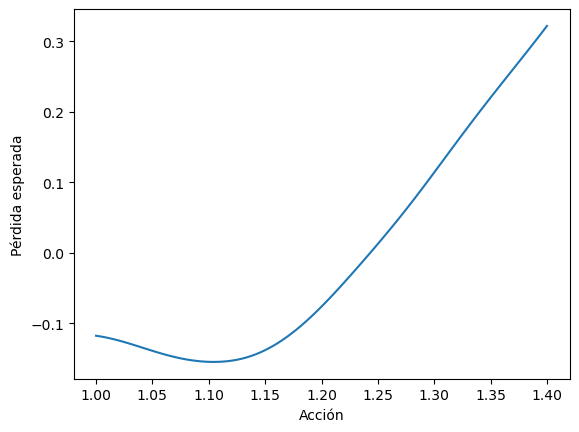

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# Generate x values between 1 and 3
x_values = np.linspace(1, 1.4, 100)

# Calculate corresponding y values using the objective function
y_values = [f_optim(x)/N4 for x in x_values]

# Plot the function
plt.plot(x_values, y_values, label='f_optim(x)')

# Add labels and title
plt.xlabel('Acción')
plt.ylabel('Pérdida esperada')
#plt.title('Plot of f_optim(x) between 1 and 1.5')

# Show the legend
# plt.legend()

# Show the plot
plt.show()


In [9]:
minimize(f_optim, 1.1, bounds = [(1, 5)])

      fun: -46.34261395806203
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.84217096e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([1.10427322])

In [10]:
# Cálculo de d(y)
N5 = 1000 # muestras en la integral
aux_acciones = np.random.randint(0, N3, N5)
acciones = np.array([A[n] for n in aux_acciones])
theta_i = np.random.normal(10, 1, N5)
p_i_x_theta=norm(theta_i,theta_i/30)

for y in np.linspace(7,13,601):
    print( y, np.dot( (theta_0 - theta_i) , p_i_x_theta.pdf(y/acciones) ) )


7.0 3.24117419523272
7.01 3.415005531180862
7.02 3.59416195556963
7.03 3.778630347633486
7.04 3.9684004705293683
7.05 4.16346680433178
7.06 4.3638304107269645
7.07 4.5695008012866465
7.08 4.7804977793051835
7.09 4.996853223663466
7.1 5.218612782083922
7.11 5.4458374405088685
7.12 5.678604935202773
7.13 5.9170109745793145
7.14 6.161170238704882
7.15 6.411217125945821
7.16 6.66730621830736
7.17 6.92961243965198
7.18 7.198330884163838
7.19 7.473676296118403
7.2 7.755882186180606
7.21 8.045199574045858
7.22 8.341895352194475
7.23 8.646250270789618
7.24 8.95855654923388
7.25 9.279115125533385
7.26 9.60823256031222
7.27 9.946217617988586
7.28 10.293377553173348
7.29 10.65001413569103
7.3 11.016419452663547
7.31 11.392871530746882
7.32 11.779629825792055
7.33 12.176930630831384
7.34 12.584982456304742
7.35 13.003961438771505
7.36 13.434006835956945
7.37 13.875216666812124
7.38 14.327643555299183
7.39 14.791290835830523
7.4 15.266108976691697
7.41 15.751992375370166
7.42 16.248776576521742
7.4

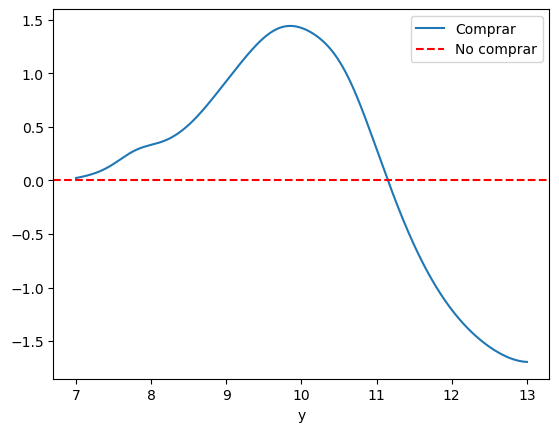

In [11]:
y_values = np.linspace(7, 13, 601)

results = [y * np.dot((theta_0 - theta_i), p_i_x_theta.pdf(y/acciones)) / N5 for y in y_values]
plt.plot(y_values, results, label='Comprar')
plt.axhline(y=0, color='red', linestyle='--', label='No comprar')
plt.xlabel('y')
plt.legend()
plt.show()

In [14]:
[[y_values[n], results[n]] for n in range(400,601)]

[[1.4266666666666667, False],
 [1.4299833333333334, False],
 [1.4333, False],
 [1.4366166666666667, False],
 [1.4399333333333333, False],
 [1.4432500000000001, False],
 [1.4465666666666668, False],
 [1.4498833333333334, False],
 [1.4532, False],
 [1.4565166666666667, False],
 [1.4598333333333333, False],
 [1.46315, False],
 [1.4664666666666668, False],
 [1.4697833333333334, False],
 [1.4731, False],
 [1.4764166666666667, False],
 [1.4797333333333333, False],
 [1.48305, False],
 [1.4863666666666666, False],
 [1.4896833333333335, False],
 [1.493, False],
 [1.4963166666666667, False],
 [1.4996333333333334, False],
 [1.50295, False],
 [1.5062666666666666, False],
 [1.5095833333333333, False],
 [1.5129000000000001, False],
 [1.5162166666666668, False],
 [1.5195333333333334, False],
 [1.52285, False],
 [1.5261666666666667, False],
 [1.5294833333333333, False],
 [1.5328, False],
 [1.5361166666666668, False],
 [1.5394333333333334, False],
 [1.54275, False],
 [1.5460666666666667, False],
 [1.54

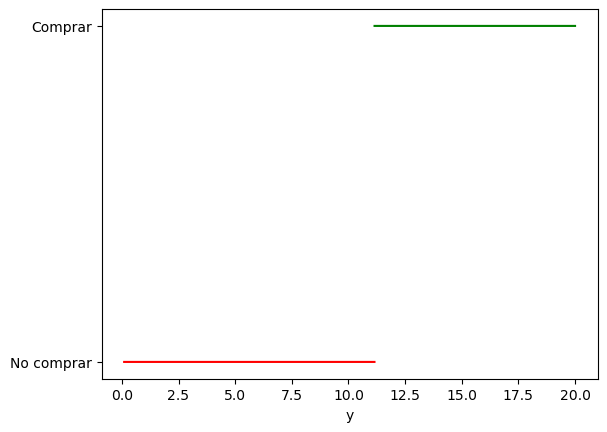

In [17]:
# Values for y
y_values = np.linspace(0.1, 20, 6001)

# Calculate the results
results = np.array([(y * np.dot((theta_0 - theta_i), p_i_x_theta.pdf(y/acciones)) / N5) < 0 for y in y_values])

# Create a plot with non-continuous line segments
plt.plot(y_values[results], results[results], color='green', label='Comprar')
plt.plot(y_values[~results], results[~results], color='red', label='No comprar')

# Add labels and title
plt.xlabel('y')

# Customize y-axis labels
plt.yticks([0, 1], ['No comprar', 'Comprar'])


# Show the plot
plt.show()
